# Back Testing Statistics
Chapter 6 of the book: "Build Your Own AI Investor"

In [3]:
# Code from Book: Build Your Own AI Investor
# Damon Lee 2021
# Check out the performance on www.valueinvestingai.com
# Code uses data from the (presumably) nice people at https://simfin.com/. 
# Feel free to fork this code for others to see what can be done with it.

In [4]:
from platform import python_version
print(python_version())

3.9.17


In [5]:
import pandas as pd
import numpy as np
import math
import pickle # get the ML model from other notebook
from matplotlib import pyplot as plt # scatter plot
import matplotlib.lines as mlines # plot

In [6]:
# Set the plotting DPI settings to be a bit higher.
plt.rcParams['figure.figsize'] = [7.0, 4.5]
plt.rcParams['figure.dpi'] = 150

In [7]:
# X AND Y
# The backtester needs dates from the old y vector 
# to plot the stock prices.

# Financial ratios 
X=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv", 
              index_col=0)

# Annual stock performances, with date data.
y_withData=pd.read_csv("Annual_Stock_Price_Performance_Filtered.csv", 
                       index_col=0)

# Convert to date
y_withData["Date"] = pd.to_datetime(y_withData["Date"])
y_withData["Date2"] = pd.to_datetime(y_withData["Date2"])

# X AND Y (splitting for train/test done previously for trained model)
X_train=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_train.csv", 
                    index_col=0)
X_test=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_test.csv", 
                   index_col=0)
y_train=pd.read_csv("Annual_Stock_Price_Performance_Percentage_train.csv", 
                    index_col=0)
y_test=pd.read_csv("Annual_Stock_Price_Performance_Percentage_test.csv", 
                   index_col=0)

# Get y_withData to correspond to y_test
y_withData_Test=pd.DataFrame()
y_withData_Test=y_withData.loc[y_test.index, :]

# Convert string to datetime
y_withData_Test["Date"] = pd.to_datetime(y_withData_Test["Date"])
y_withData_Test["Date2"] = pd.to_datetime(y_withData_Test["Date2"])

In [8]:
y_withData_Test.head()

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
20071,NYMX,7.92,2012-03-15,4.894560e+05,NYMX,4.83,2013-03-15,697935.00
17799,MNK,26.09,2017-11-07,8.944057e+08,MNK,29.88,2018-11-07,68589838.80
15017,KE,23.53,2021-08-27,4.432699e+06,KE,21.76,2022-08-29,819438.08
5496,CHE,532.84,2023-02-27,4.448681e+07,CHE,599.74,2024-02-27,56335377.42
21192,PCYG,5.40,2021-09-28,2.695734e+05,PCYG,5.91,2022-09-28,666848.94


In [9]:
y_withData.head()

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
0,A,28.40,2002-01-22,44130760.0,A,17.55,2003-01-22,38576655.0
1,A,16.80,2002-12-20,61365360.0,A,28.00,2003-12-22,57271200.0
2,A,28.00,2003-12-22,57271200.0,A,23.52,2004-12-21,42705264.0
3,A,23.52,2004-12-21,42705264.0,A,34.99,2005-12-21,147356886.0
4,A,33.67,2006-01-17,84215404.0,A,33.43,2007-01-17,89027433.0


In [10]:
y_train

,Perf
8865,-0.460949
16545,0.792127
30230,-0.148021
12366,0.724138
30849,0.397092
...,...
29802,0.459129
5390,-0.341004
860,0.765517
15795,0.309470


# Functions
A little different from previous chapter code

In [11]:
def calcZScores(X):
    '''
    Calculate Altman Z'' scores 1995
    '''
    Z = pd.DataFrame()
    Z['Z score'] = 3.25 \
    + 6.51 * X['(CA-CL)/TA']\
    + 3.26 * X['RE/TA']\
    + 6.72 * X['EBIT/TA']\
    + 1.05 * X['Book Equity/TL']
    return Z

def getYRawData(directory='C:/Users/damon/OneDrive/BYO_Investing_AI/2024/Stock_Data/SimFin2024/'):
    '''
    Can set directory to look for file in.
    Get daily stock price time series for ALL stocks. 
    5M rows. Some days missing.
    Returns DataFrame
    '''
    daily_stock_prices=pd.read_csv(directory+'us-shareprices-daily.csv',
                                   delimiter=';')
    daily_stock_prices["Date"]=pd.to_datetime(daily_stock_prices["Date"])
    print('Reading historical time series stock data, matrix size is: ', 
          daily_stock_prices.shape)
    return daily_stock_prices

def getYPerf(y_):
    y=pd.DataFrame()
    y["Ticker"] = y_["Ticker"]
    y["Perf"]=(y_["Open Price2"]-y_["Open Price"])/y_["Open Price"]
    y[y["Perf"].isnull()]=0
    return y

def getStockPriceBetweenDates(date1, date2, ticker, d, rows):
    rows = d.loc[(d["Date"]>date1) &\
                 (d["Date"]<date2) &\
                 (d["Ticker"]==ticker)]
    return rows

def getStockPriceData(dateTimeIndex, ticker, y_withData, mask, daily_stock_prices, rows):
    '''
    Get the stock price for a ticker
    between the buy/sell date (using y_withdata)
    2021 version change to select from March to March only, 
    go for more corresponding backtest to reality,
    rather than attampting to match the training data closely.
    '''
    #date1 = y_withData[mask][y_withData[mask]["Ticker"] == ticker]["Date"].values[0]
    #date2 = y_withData[mask][y_withData[mask]["Ticker"] == ticker]["Date2"].values[0]
    date1 = dateTimeIndex[0]
    date2 = dateTimeIndex[-1]
    rows = getStockPriceBetweenDates(date1, date2,\
                                     ticker, daily_stock_prices, rows)
    return rows

def getDataForDateRange(date_Index_New, rows):
    '''
    Given a date range(index), and a series of rows,
    that may not correspond exactly,
    return a DataFrame that gets rows data,
    for each period in the date range(index)
    '''
    WeeklyStockDataRows = pd.DataFrame()
    for I in date_Index_New:
        #WeeklyStockDataRows = WeeklyStockDataRows.append(\
        #  rows.iloc[rows.index.get_loc(I, method="nearest")])
        #WeeklyStockDataRows = pd.concat([WeeklyStockDataRows, 
        #                                 rows.iloc[rows.index.get_indexer(I, method="nearest")]], ignore_index=True)
        WeeklyStockDataRows = pd.concat([WeeklyStockDataRows, 
                                         rows.iloc[rows.index.get_indexer([pd.to_datetime(I)], method="nearest")]], 
                                         ignore_index=True)
    return WeeklyStockDataRows

def getStockTimeSeries(dateTimeIndex, y_withData, 
                       tickers, mask, daily_stock_prices):
    '''
    Get the stock price as a time series DataFrame
    for a list of tickers.
    A mask is used to only consider stocks for a certain period.
    dateTimeIndex is typically a weekly index,
    so we know what days to fetch the price for.
    '''
    stockRet = pd.DataFrame(index=dateTimeIndex)
    dTI_new = dateTimeIndex.strftime('%Y-%m-%d') # Change Date Format
    rows = pd.DataFrame()
    for tick in tickers:
        # Here "rows" is stock price time series data 
        # for individual stock
        rows = getStockPriceData(dateTimeIndex,
                                 tick, 
                                 y_withData, 
                                 mask, 
                                 daily_stock_prices, 
                                 rows)
        rows.index = pd.DatetimeIndex(rows["Date"])
        WeeklyStockDataRows = getDataForDateRange(dTI_new,
                                                  rows)
        # Here can use Open, Close, Adj. Close, etc. price
        stockRet[tick] = WeeklyStockDataRows["Close"].values
    return stockRet

def getPortfolioRelativeTimeSeries(stockRet):
    '''
    Takes DataFrame of stock returns, one column per stock
    Normalises all the numbers so the price at the start is 1.
    Adds a column for the portfolio value.
    '''    
    for key in stockRet.keys():
        stockRet[key]=stockRet[key]/stockRet[key][0]
    stockRet["Portfolio"] = stockRet.sum(axis=1)/(stockRet.keys().shape[0])
    return stockRet

In [12]:
def getPortTimeSeriesForYear(date_starting, y_withData, X, 
                             daily_stock_prices, ml_model_pipeline):
    '''
    Function runs a backtest.
    Returns DataFrames of selected stocks/portfolio performance,
    for 1 year.
    y_withData is annual stock performances (all backtest years)
    date_starting e.g. '2010-01-01'
    daily_stock_prices is daily(mostly) stock price time series for
    all stocks
    '''
    
    # get y dataframe with ticker performance only
    y = getYPerf(y_withData)
    
    # Get performance only for time frame we care about,
    # mask original data using the start date
    thisYearMask = y_withData["Date"].between(\
              pd.to_datetime(date_starting) - pd.Timedelta(days=120),######
              pd.to_datetime(date_starting))
    
    
    # Get return prediction from model
    y_pred = ml_model_pipeline.predict(X[thisYearMask])
    
    # Make it a DataFrame to select the top picks
    y_pred = pd.DataFrame(y_pred)
    
    ##### Change in code for Z score filtering ##### 
    # Separate out stocks with low Z scores
    z = calcZScores(X)
    
    # 3.75 is approx. B- rating
    bl_safeStocks=(z['Z score'][thisYearMask].reset_index(drop=True)>2) 
    y_pred_z = y_pred[bl_safeStocks]
    
    # Get bool list of top stocks
    bl_bestStocks=(
        y_pred_z[0]>y_pred_z.nlargest(8,0).tail(1)[0].values[0]) 
    
    dateTimeIndex = pd.date_range(\
                          start=date_starting, periods=52, freq='W')
    
    # 7 greatest performance stocks of y_pred 
    ticker_list = \
    y[thisYearMask].reset_index(drop=True)\
                      [bl_bestStocks&bl_safeStocks]["Ticker"].values
    ##### Change in code for Z score filtering ##### 
    
    # After we know our stock picks, we get the stock performance
    # Get DataFrame index of time stamp, series of stock prices, 
    # keys=tickers
    stockRet = getStockTimeSeries(dateTimeIndex, y_withData,
                                  ticker_list, thisYearMask, 
                                  daily_stock_prices)
    
    # Get DataFrame of relative stock prices from 1st day(or close) 
    # and whole portfolio
    stockRetRel = getPortfolioRelativeTimeSeries(stockRet)
    return [stockRetRel, stockRetRel["Portfolio"], ticker_list]

def getPortTimeSeries(y_withData, X, daily_stock_prices, ml_model_pipeline, verbose=True):
    '''
    Returns DataFrames of selected stocks/portfolio performance since 2009.
    Needs X and y(with data), the daily_stock_prices DataFrame,
    the model pipeline we want to test.
    X is standard X for model input.
    y_withData is the stock price before/after df with date information.
    Input X and y must be data that the model was not trained on.
    '''
    # set date range to make stock picks over
    dr=pd.date_range(start='2005-01-01', periods=17, freq='Y') + pd.to_timedelta('9w') # start every March
    # For each date in the date_range, make stock selections
    # and plot the return results of those stock selections
    port_perf_all_years = pd.DataFrame()
    perfRef=1 # performance starts at 1.
    for curr_date in dr:
        
        [comp, this_year_perf, ticker_list] = \
        getPortTimeSeriesForYear(curr_date, y_withData, X,\
                                 daily_stock_prices, ml_model_pipeline)
        
        if verbose: # If you want text output
            print("Backtest performance for year starting ",\
                  curr_date, " is:",\
                  round((this_year_perf.iloc[-1]-1)*100,2), "%")
            print("With stocks:", ticker_list)
            for tick in ticker_list:
                print(tick, "Performance was:",\
                      round((comp[tick].iloc[-1]-1)*100,2), "%" )
            print("---------------------------------------------")
        
        # Stitch performance for every year together
        this_year_perf = this_year_perf * perfRef
        #print(comp)
        port_perf_all_years = pd.concat([port_perf_all_years,\
                                         this_year_perf])
        
        perfRef = this_year_perf.iloc[-1]
    
    # Return portfolio performance for all years
    port_perf_all_years.columns = ["Indexed Performance"]
    return port_perf_all_years

# Try out a single backtest

In [13]:
# backtest data
daily_stock_prices=getYRawData()

Reading historical time series stock data, matrix size is:  (17999010, 11)


In [10]:
#pl_linear.p, pl_ElasticNet.p, pl_KNeighbors.p, pl_rfregressor.p, pl_decTree.p, pl_svm.p
#pl_linear = pickle.load(open("pl_linear.p", "rb" ))
pl_linear = pickle.load(open("pl_rfregressor.p", "rb" ))
test = getPortTimeSeries(y_withData_Test, X_test,
                         daily_stock_prices,
                         pl_linear)
print('Performance is: ', 100 * (test["Indexed Performance"][-1]-1), '%')

C:\Users\damon\.conda\envs\AIInvestor\lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.22.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ValueError: node array from the pickle has an incompatible dtype:
- expected: {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}
- got     : [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]

<Axes: >

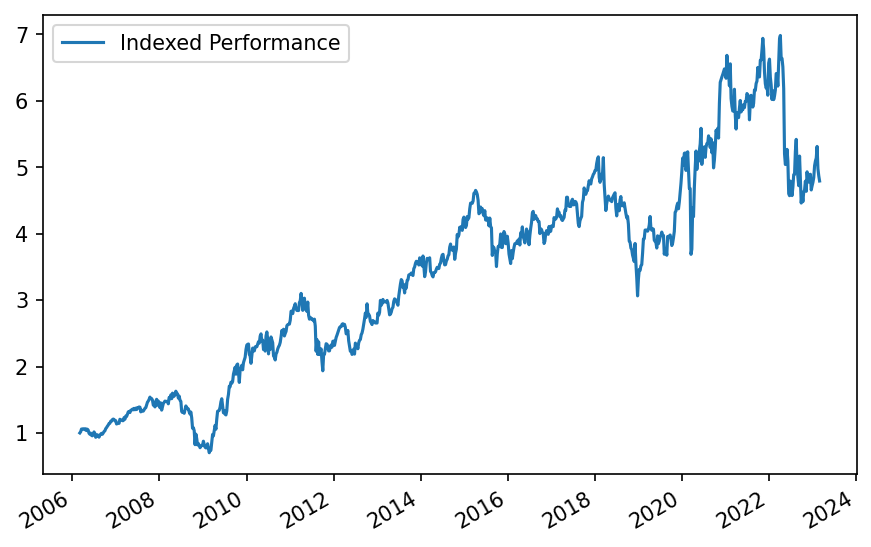

In [95]:
test.plot()

# Now loop through model tests and get some statistics to work with.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import pickle

In [15]:
# Linear model pipeline
def trainLinearModel(X_train, y_train):
    pl_linear = Pipeline([('Power Transformer', PowerTransformer()),
        ('linear', LinearRegression())])
    pl_linear.fit(X_train, y_train)
    return pl_linear

# ElasticNet model pipeline
def trainElasticNetModel(X_train, y_train):
    pl_ElasticNet = Pipeline([('Power Transformer', PowerTransformer()),
        ('ElasticNet', ElasticNet(l1_ratio=0.00001))])
    pl_ElasticNet.fit(X_train, y_train)
    return pl_ElasticNet

# KNeighbors regressor
def trainKNeighborsModel(X_train, y_train):
    pl_KNeighbors = Pipeline([('Power Transformer', PowerTransformer()),
        ('KNeighborsRegressor', KNeighborsRegressor(n_neighbors=40))])
    pl_KNeighbors.fit(X_train, y_train)
    return pl_KNeighbors

# DecisionTreeRegressor
def traindecTreeModel(X_train, y_train):
    pl_decTree = Pipeline([
        ('DecisionTreeRegressor',\
         DecisionTreeRegressor(max_depth=20, random_state=42))
    ])
    pl_decTree.fit(X_train, y_train)
    return pl_decTree

# RandomForestRegressor
def trainrfregressorModel(X_train, y_train):
    pl_rfregressor = Pipeline([
        ('RandomForestRegressor',\
         RandomForestRegressor(max_depth=10, random_state=42))
    ])
    pl_rfregressor.fit(X_train, y_train)
    
    return pl_rfregressor

# GradientBoostingRegressor
def traingbregressorModel(X_train, y_train):
    pl_GradBregressor = Pipeline([
        ('GradBoostRegressor',\
         GradientBoostingRegressor(n_estimators=100,\
                                   learning_rate=0.1,\
                                   max_depth=14,\
                                   random_state=42,\
                                   loss='absolute_error'))  ])
    pl_GradBregressor.fit(X_train, y_train)
    
    return pl_GradBregressor

# SVM
def trainsvmModel(X_train, y_train):
    pl_svm = Pipeline([('Power Transformer', PowerTransformer()),
        ('SVR', SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1))])
    pl_svm.fit(X_train, y_train)
    return pl_svm

## Try and find a good train/test split proportion (rough)

In [14]:
# Y percentage perf
y_pec=pd.read_csv("Annual_Stock_Price_Performance_Percentage.csv", index_col=0)["Perf"]

In [56]:
model_pipeline_list = ['pl_linear', 'pl_KNeighbors', 'pl_decTree',\
                       'pl_GradBregressor', 'pl_rfregressor', 'pl_svm']

for model in model_pipeline_list:
    for myTstSze in [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]:
        X_train,X_test,y_train,y_test=train_test_split(X, y_pec,
                                                       test_size=myTstSze)
        
        if (model =='pl_ElasticNet'):
            model_pl = trainElasticNetModel(X_train, y_train)
        if (model =='pl_KNeighbors'):
            model_pl = trainKNeighborsModel(X_train, y_train)
        if (model =='pl_decTree'):
            model_pl = traindecTreeModel(X_train, y_train)
        if (model =='pl_rfregressor'):
            model_pl = trainrfregressorModel(X_train, y_train)
        if (model =='pl_GradBregressor'):
            model_pl = traingbregressorModel(X_train, y_train)
        if (model =='pl_svm'):
            model_pl = trainsvmModel(X_train, y_train)
        else:
            # Linear model default
            model_pl = trainLinearModel(X_train, y_train) 
            
        y_withData_Test=y_withData.loc[X_test.index]
        
        # Here is our backtesting code
        test = getPortTimeSeries(y_withData_Test, X_test,
                                 daily_stock_prices, 
                                 model_pl,
                                 verbose=False) 
        
        perf = test['Indexed Performance'][-1]
        vol = test['Indexed Performance'].diff().std()*np.sqrt(52)
        print('Performance:', round(perf, 2), 
              'Volatility:', round(vol,2),
              'Model', model, 'Test size: ', myTstSze)

Performance: 4.69 Volatility: 0.6 Model pl_linear Test size:  0.02
Performance: 5.08 Volatility: 0.8 Model pl_linear Test size:  0.1
Performance: 2.55 Volatility: 0.42 Model pl_linear Test size:  0.25
Performance: 1.36 Volatility: 0.29 Model pl_linear Test size:  0.5
Performance: 3.69 Volatility: 0.57 Model pl_linear Test size:  0.75
Performance: 4.69 Volatility: 0.73 Model pl_linear Test size:  0.9
Performance: 9.1 Volatility: 1.29 Model pl_linear Test size:  0.98
Performance: 2.5 Volatility: 0.37 Model pl_KNeighbors Test size:  0.02
Performance: 2.09 Volatility: 0.43 Model pl_KNeighbors Test size:  0.1
Performance: 2.48 Volatility: 0.37 Model pl_KNeighbors Test size:  0.25
Performance: 3.06 Volatility: 0.62 Model pl_KNeighbors Test size:  0.5
Performance: 2.93 Volatility: 0.77 Model pl_KNeighbors Test size:  0.75
Performance: 2.13 Volatility: 0.26 Model pl_KNeighbors Test size:  0.9
Performance: 3.75 Volatility: 0.68 Model pl_KNeighbors Test size:  0.98
Performance: 5.99 Volatility: 

## Now getting the backtesting statistics proper
Can run in parallel, takes awhile.

In [15]:
def getResultsForModel(model_pipeline_list, runs_per_model=1, verbose=True):
    '''
    getResultsForModel
    Choose the model pipelines to run loop for.
    '''
    i, results = 0, []
    for model in model_pipeline_list:
        for test_num in range(0, runs_per_model):
            X_train,X_test,y_train,y_test=train_test_split(X, y_pec,
                                                           test_size=0.5
                                                          )
            #Train different models
            if (model =='pl_linear'):
                model_pl = trainLinearModel(X_train, y_train)
            if (model =='pl_ElasticNet'):
                model_pl = trainElasticNetModel(X_train, y_train)
            if (model =='pl_KNeighbors'):
                model_pl = trainKNeighborsModel(X_train, y_train)
            if (model =='pl_rfregressor'):
                model_pl = trainrfregressorModel(X_train, y_train)
            if (model =='pl_decTree'):
                model_pl = traindecTreeModel(X_train, y_train)
            if (model =='pl_GradBregressor'):
                model_pl = traingbregressorModel(X_train, y_train)
            if (model =='pl_svm'):
                model_pl = trainsvmModel(X_train, y_train)
            y_withData_Test=y_withData.loc[X_test.index]

            # Here is our backtesting code
            test = getPortTimeSeries(y_withData_Test, X_test,
                                 daily_stock_prices, model_pl, 
                                     verbose=False) 
            
            perf = test['Indexed Performance'][-1]
            vol = test['Indexed Performance'].diff().std()*np.sqrt(52)
            if verbose:
                print('Performed test ',i , [i, model, perf, vol])
            results.append([i, model, perf, vol])
            i=i+1

    # Save our results for plotting
    results_df = pd.DataFrame(results, columns=["Test Number",\
                                                "Model Used",\
                                                "Indexed Return",\
                                                "Annual Volatility"])

    # Append to an existing results file if available, 
    # else make new results file.
    # In parallel there is an extremely remote chance 
    # two cores try and access file at same time. 
    # To keep code simple this is OK.
    import os
    if os.path.isfile("backtest_statistics.csv"):
        results_df.to_csv("backtest_statistics.csv", 
                          mode='a', 
                          header=False)
    else:
        results_df.to_csv("backtest_statistics.csv")

In [18]:
# Run with 1 core
#model_pipeline_list = ['pl_KNeighbors']
#model_pipeline_list = ['pl_rfregressor', 
#                       'pl_decTree', 
#                       'pl_svm', 
#                       'pl_linear', 
#                       'pl_GradBregressor', 
#                       'pl_KNeighbors', 
#                       'pl_ElasticNet']
model_pipeline_list = ['pl_KNeighbors']

getResultsForModel(model_pipeline_list, 1)

Performed test  0 [0, 'pl_KNeighbors', 46.23516639542124, 5.417813581053542]


In [85]:
#Run in Parallel
# Specific models on each core
# Can run this many times, will just keep appending to results file.
#model_pipeline_list_list = [['pl_GradBregressor', 'pl_ElasticNet'],
#                            ['pl_decTree', 'pl_rfregressor'],
#                            ['pl_svm'],
#                            ['pl_linear', 'pl_KNeighbors']]

model_pipeline_list_list = [['pl_rfregressor'],
                            ['pl_decTree'],
                            ['pl_linear'],
                            ['pl_KNeighbors'],
                            ['pl_ElasticNet'],
                            ['pl_GradBregressor'],
                            ['pl_rfregressor'],
                            ['pl_decTree'],
                            ['pl_linear'],
                            ['pl_KNeighbors'],
                            ['pl_ElasticNet'],
                            ['pl_GradBregressor']]

import threading
l = len(model_pipeline_list_list)

thread_list = []
for i in range(l):
    thread = threading.Thread(target=getResultsForModel, args=(model_pipeline_list_list[i], 3, False))
    thread_list.append(thread)
    thread.start()
    print('Thread '+str(i)+' started.')
# start time for 3 runs of all models bar svm: 11:47
# end time is: 

Thread 0 started.
Thread 1 started.
Thread 2 started.
Thread 3 started.
Thread 4 started.
Thread 5 started.
Thread 6 started.
Thread 7 started.
Thread 8 started.
Thread 9 started.
Thread 10 started.
Thread 11 started.


In [188]:
#Run in Parallel
# Specific models on each core
# Can run this many times, will just keep appending to results file.
#model_pipeline_list_list = [['pl_GradBregressor', 'pl_ElasticNet'],
#                            ['pl_decTree', 'pl_rfregressor'],
#                            ['pl_svm'],
#                            ['pl_linear', 'pl_KNeighbors']]

model_pipeline_list_list = [['pl_rfregressor'],
                            ['pl_decTree'],
                            ['pl_KNeighbors'],
                            ['pl_GradBregressor'],
                            ['pl_rfregressor'],
                            ['pl_decTree'],
                            ['pl_KNeighbors'],
                            ['pl_GradBregressor'],
                            ['pl_rfregressor'],
                            ['pl_decTree'],
                            ['pl_KNeighbors'],
                            ['pl_GradBregressor']]

import threading
l = len(model_pipeline_list_list)

thread_list = []
for i in range(l):
    thread = threading.Thread(target=getResultsForModel, args=(model_pipeline_list_list[i], 45, False))
    thread_list.append(thread)
    thread.start()
    print('Thread '+str(i)+' started.')
# start time for 3 runs of all models bar svm: 11:47
# end time is: 12:24
# 37 mins per run, gradB approx 2x.

Thread 0 started.
Thread 1 started.
Thread 2 started.
Thread 3 started.
Thread 4 started.
Thread 5 started.
Thread 6 started.
Thread 7 started.
Thread 8 started.
Thread 9 started.
Thread 10 started.
Thread 11 started.


In [191]:
# Can check if threads are still running any time.
# Notebook will look as though nothing is running
# But things are running in background.
for i in thread_list:
    print(i.is_alive())

False
False
False
False
False
False
False
False
False
False
False
False


# Investigating Backtest Statistics

In [192]:
results_df = pd.read_csv('backtest_statistics.csv', index_col=0)
results_df.reset_index(inplace=True, drop=True)
results_df

,Test Number,Model Used,Indexed Return,Annual Volatility
0,0,pl_KNeighbors,18.453717,2.211989
1,0,pl_KNeighbors,46.235166,5.417814
2,0,pl_linear,23.905311,6.215504
3,0,pl_linear,13.883234,3.013904
4,0,pl_decTree,11.731885,1.827768
5,0,pl_GradBregressor,235.197263,30.526038
6,0,pl_rfregressor,40.282516,7.490015
7,0,pl_decTree,10.364181,2.098436
8,0,pl_linear,18.564142,2.888061
9,0,pl_ElasticNet,35.871731,5.497028


In [193]:
def plotBacktestDist(results_df, model_file, col):
    ax=results_df[results_df['Model Used']==model_file][col].hist(\
                                    bins=50, density=True, alpha=0.7)
    
    ax2=results_df[results_df['Model Used']==model_file][col].plot.kde(\
                                    alpha=0.9)
    
    max_val=results_df[results_df['Model Used']==model_file][col].max()
    ax.set_xlabel(col)
    ax.set_ylabel('Normalised Frequency')
    ax.set_title('{} Backtest Distribution for {}, {} Runs'.format(\
          col,\
          model_file,\
          results_df[results_df['Model Used']==model_file][col].size))
    ax.grid()
    mean=results_df[results_df['Model Used']==model_file][col].mean()
    ymin, ymax = ax.get_ylim()
    
    if (col=='Indexed Return'): 
        # Plot S&P 500 returns
        # begin 2010 -> end 2020
        ax.plot([3.511822, 3.511822], [ymin, ymax],\
                color='r', linestyle='-', linewidth=1.5, alpha=1)
        ax.plot([mean, mean], [ymin, ymax],\
                color='lime', linestyle='--', linewidth=1.5, alpha=1)
        #plt.xlim(0, 15)
    
    if (col=='Annual Volatility'): 
        # Plot S&P 500 volatility
        # begin 2010 -> end 2020
        ax.plot([0.325059094152396, 0.325059094152396], [ymin, ymax],\
                color='r', linestyle='-', linewidth=2)  
        ax.plot([mean, mean], [ymin, ymax],\
                color='lime', linestyle='--', linewidth=2)  
        #plt.xlim(0, 1.5)
    ax.legend(['Fitted Smooth Kernel','S&P500 Benchmark', \
               'Simulation Mean {}'.format(round(mean,2)),\
               'Simulation Backtests'], loc = 'upper right')

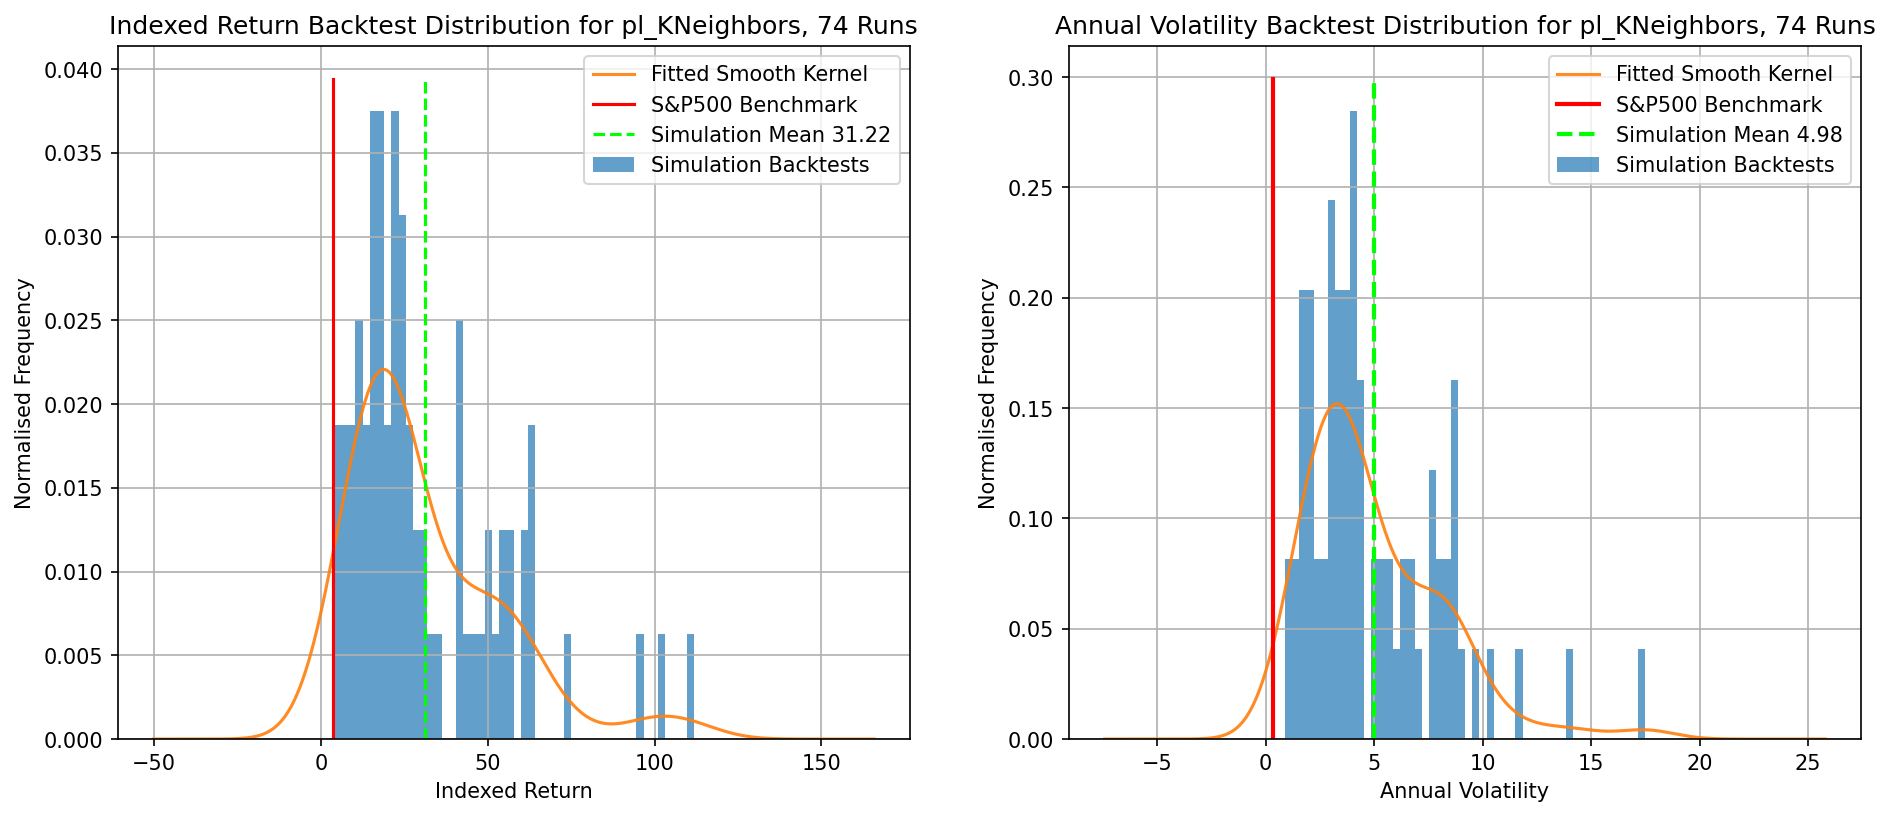

In [164]:
#model_file = #['pl_linear', 'pl_ElasticNet', 'pl_rfregressor', 'pl_decTree', 'pl_svm', 'pl_KNeighbors, pl_GradBregressor']
model_file = 'pl_KNeighbors'
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plotBacktestDist(results_df, model_file, 'Indexed Return')
plt.subplot(1,2,2)
plotBacktestDist(results_df, model_file, 'Annual Volatility')

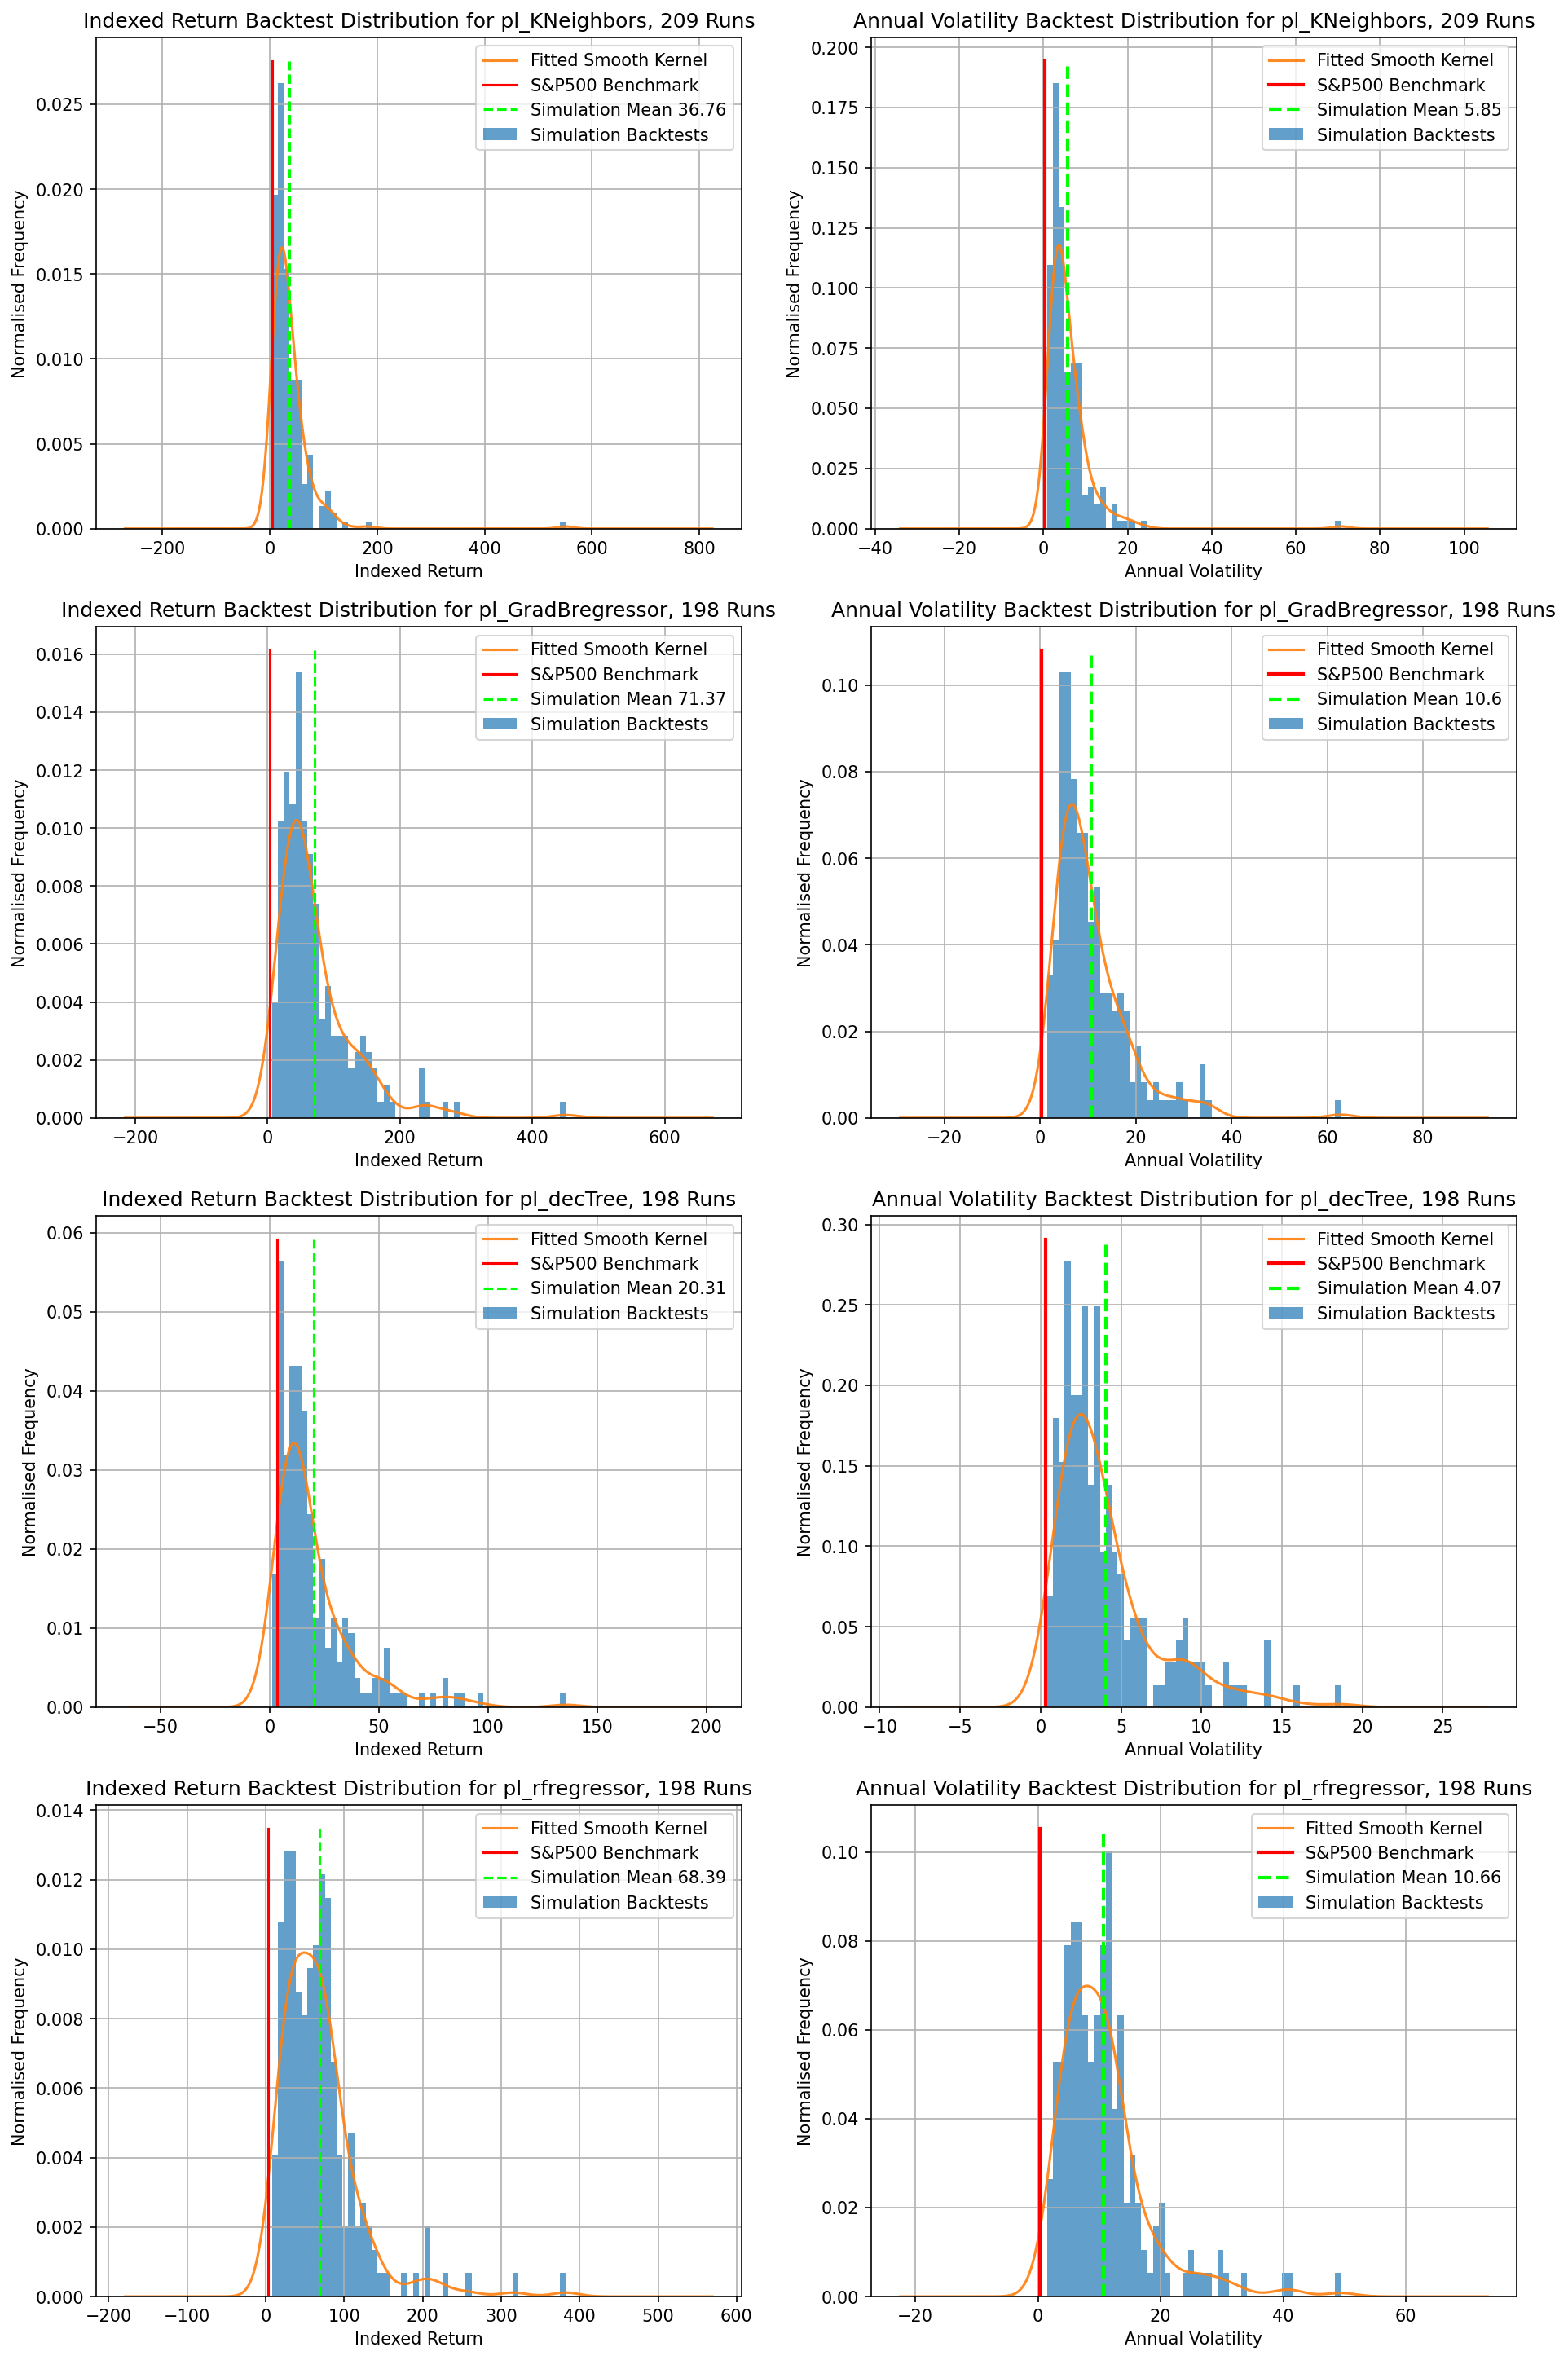

In [194]:
#model_file = ['pl_ElasticNet','pl_decTree', 'pl_rfregressor', 'pl_svm', 'pl_KNeighbors', 'pl_GradBregressor']
#model_file = ['pl_linear', 'pl_ElasticNet']
#model_file = ['pl_decTree', 'pl_rfregressor', 'pl_svm']
model_file = ['pl_KNeighbors', 'pl_GradBregressor', 'pl_decTree', 'pl_rfregressor']
#model_file = ['pl_rfregressor']
numPlots = len(model_file)
plt.figure(figsize=(15,6*numPlots))
for I in range(0, numPlots):
    plt.subplot(numPlots,2,I*2+1)
    plotBacktestDist(results_df, model_file[I], 'Indexed Return')
    plt.subplot(numPlots,2,I*2+2)
    plotBacktestDist(results_df, model_file[I], 'Annual Volatility')

# Chosen Regressors for AI are GradBoost and KNN

We will expect more volatility.

Text(0.5, 1.0, 'KNN Backtest Return vs. Volatility')

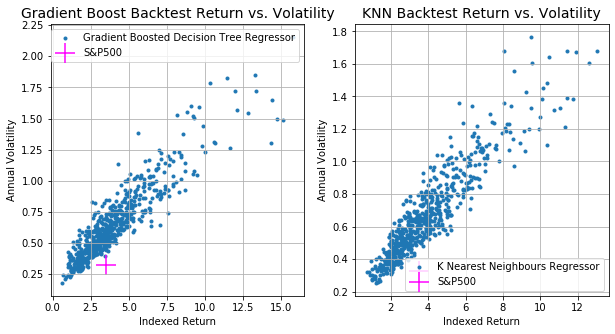

In [207]:
# GRAPH OF RETURN VS VOLATILITY
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
returns = results_df[results_df['Model Used']=='pl_GradBregressor']['Indexed Return']
vols = results_df[results_df['Model Used']=='pl_GradBregressor']['Annual Volatility']
plt.scatter(returns, vols, marker='.')
plt.scatter(3.511822, 0.325059094152396, marker='+', color='fuchsia', s=400)
plt.xlabel('Indexed Return')
plt.ylabel('Annual Volatility')
plt.grid()
plt.legend(['Gradient Boosted Decision Tree Regressor', 'S&P500'])
plt.title('Gradient Boost Backtest Return vs. Volatility', fontsize=14)

plt.subplot(1,2,2)
returns = results_df[results_df['Model Used']=='pl_KNeighbors']['Indexed Return']
vols = results_df[results_df['Model Used']=='pl_KNeighbors']['Annual Volatility']
plt.scatter(returns, vols, marker='.')
plt.scatter(3.511822, 0.325059094152396, marker='+', color='fuchsia', s=400)
plt.xlabel('Indexed Return')
plt.ylabel('Annual Volatility')
plt.grid()
plt.legend(['K Nearest Neighbours Regressor', 'S&P500'])
plt.title('KNN Backtest Return vs. Volatility', fontsize=14)

Text(0.5, 0, 'Annual Volatility')

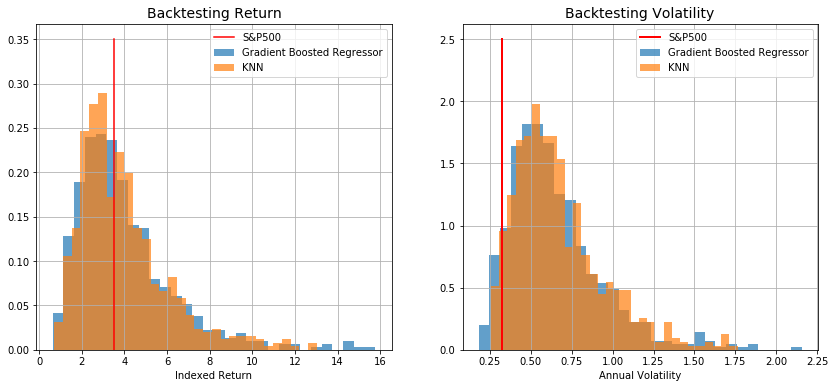

In [208]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
results_df[results_df['Model Used']=='pl_GradBregressor']['Indexed Return'].hist(bins=30,\
                                                density=True, alpha=0.7)
results_df[results_df['Model Used']=='pl_KNeighbors']['Indexed Return'].hist(bins=30,\
                                                density=True, alpha=0.7)
plt.plot([3.511822, 3.511822], [0, 0.35],\
                 color='r', linestyle='-', linewidth=1.5, alpha=1)
plt.legend(['S&P500','Gradient Boosted Regressor', 'KNN'])
plt.title('Backtesting Return', fontsize=14)
plt.xlabel('Indexed Return')

plt.subplot(1,2,2)
results_df[results_df['Model Used']=='pl_GradBregressor']['Annual Volatility'].hist(bins=30,\
                                                density=True, alpha=0.7)
results_df[results_df['Model Used']=='pl_KNeighbors']['Annual Volatility'].hist(bins=30,\
                                                density=True, alpha=0.7)
plt.plot([0.325059094152396, 0.325059094152396], [0, 2.5],\
                color='r', linestyle='-', linewidth=2)  
plt.legend(['S&P500','Gradient Boosted Regressor', 'KNN'])
plt.title('Backtesting Volatility', fontsize=14)
plt.xlabel('Annual Volatility')

# Figure out what the actual performance should be

In [111]:
RDFN# Choose the model pipelines to run loop for
model_pipeline_list = ['pl_GradBregressor', 'pl_KNeighbors']
tests_per_model=20

# Reduce test size and check performance to try and see a trend
# Is effectively *0.5 as test size is 1/2 of total data.
#test_size_modifier_list = [0.8, 0.6, 0.4, 0.2, 0.1, 0.05 ]
test_size_modifier_list = [0.05, 0.075]

# Results DataFrame
results_df2 = pd.DataFrame( columns=["Test Number",
                                            "Model Used",\
                                            "Test Set Size",\
                                            "Indexed Return",\
                                            "Annual Volatility"])

i, results = 0, []
for model in model_pipeline_list:
    for test_size_mod in test_size_modifier_list:
        for test_num in range(0, tests_per_model):
            
            X_train, X_test, y_train, y_test = \
            train_test_split(X, y_pec, test_size=0.5)
            
            new_test_size = round(len(X_test)//(1/test_size_mod))
            
            X_test, y_test = \
            X_test[:new_test_size], y_test[:new_test_size]
            
            if (model =='pl_KNeighbors'):
                model_pl = trainKNeighborsModel(X_train, y_train)
            if (model =='pl_GradBregressor'):
                model_pl = traingbregressorModel(X_train, y_train)
            y_withData_Test=y_withData.loc[X_test.index]

            # Here is our backtesting code
            test = getPortTimeSeries(y_withData_Test, X_test,
                     daily_stock_prices, model_pl, 
                         verbose=False) 
            
            perf = test['Indexed Performance'][-1]
            
            vol = test['Indexed Performance'].diff().std()*np.sqrt(52)
            
            #print('Performed test ',i , [i, model, new_test_size, perf, vol])     
            
            results_df2=results_df2.append(\
                        pd.DataFrame(\
                             [[i, model, new_test_size, perf, vol]],\
                                     columns=results_df2.keys()))      
            i=i+1
            
        print('For {} test size {}, Performance: {}, Vol: {}.'.format(\
              model, new_test_size, \
            results_df2['Indexed Return'].tail(tests_per_model).mean(),\
            results_df2['Annual Volatility'].tail(tests_per_model).mean()))

# Save our results for plotting
results_df2.to_csv("Backtest_statistics_Modified_test_size1.csv")

For pl_GradBregressor test size 389, Performance: 3.429326030593308, Vol: 0.4879855935279528.
For pl_GradBregressor test size 584, Performance: 3.420117982432879, Vol: 0.4772889911691413.
For pl_KNeighbors test size 389, Performance: 2.8474486347372796, Vol: 0.4414147876713498.
For pl_KNeighbors test size 584, Performance: 3.308133097819644, Vol: 0.4909097815132636.


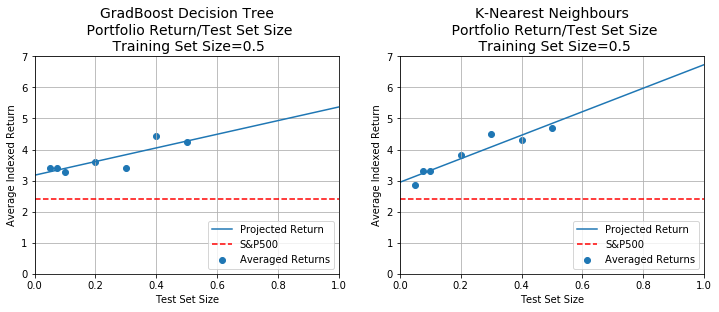

In [113]:
test_set_size = [0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05]
gradB_avgReturn = [4.23, 4.44, 3.39, 3.6, 3.29, 3.42, 3.42]
knn_avgReturn = [4.68, 4.32, 4.49, 3.83, 3.30, 3.31, 2.85]


plt.figure(figsize=(12,4))

linFit = LinearRegression().fit(np.array(test_set_size).reshape(-1,1), np.array(gradB_avgReturn).reshape(-1,1))
plt.subplot(1,2,1)
plt.scatter(test_set_size, gradB_avgReturn)
plt.xlim([0, 1])
plt.ylim([0, 7])
plt.title('GradBoost Decision Tree\n Portfolio Return/Test Set Size\n Training Set Size=0.5', fontsize=14)
plt.grid()
plt.ylabel('Average Indexed Return')
plt.xlabel('Test Set Size')
plt.plot([0,1], linFit.predict(np.array([0,1]).reshape(-1,1)),'-')
plt.plot([0,1],[2.4, 2.4],'r--')
plt.legend(['Projected Return','S&P500','Averaged Returns'],loc='lower right')


linFit = LinearRegression().fit(np.array(test_set_size).reshape(-1,1), np.array(knn_avgReturn).reshape(-1,1))
plt.subplot(1,2,2)
plt.scatter(test_set_size, knn_avgReturn)
plt.xlim([0, 1])
plt.ylim([0, 7])
plt.title('K-Nearest Neighbours\n Portfolio Return/Test Set Size\n Training Set Size=0.5', fontsize=14)
plt.grid()
plt.ylabel('Average Indexed Return')
plt.xlabel('Test Set Size')
plt.plot([0,1], linFit.predict(np.array([0,1]).reshape(-1,1)),'-')
plt.plot([0,1],[2.4, 2.4],'r--')
plt.legend(['Projected Return','S&P500','Averaged Returns'],loc='lower right')


# Final Stock Selection for 2020 with Gradient Boosted Decision Tree and K Nearest Neighbours

In [24]:
import pandas as pd

def pickStockForMe():
    '''
    Pick stocks.
    Reads Annual_Stock_Price_Fundamentals_Ratios.csv,
    and Annual_Stock_Price_Performance_Percentage.csv,
    trains the AI with the best model/parameters,
    Then picks stocks using outputs from Notebooks 1 and 2:
    Annual_Stock_Price_Fundamentals_Ratios_2021.csv,
    and Tickers_Dates_2021.csv.
    Outputs a DataFrame of best picks.
    '''
    # Training X and Y of all previous year data
    X=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv", 
                  index_col=0)
    # annual stock performances
    yperf=pd.read_csv("Annual_Stock_Price_Performance_Percentage.csv", 
                      index_col=0)
    
    yperf=yperf["Perf"]

    # Stock selection ratios for 2024 X
    X_2024=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_2024.csv"
                       , index_col=0)
    # And the row tickers
    tickers=pd.read_csv("Tickers_Dates_2024_present.csv", index_col=0)
    
    # Gradient Boosted tree
    #model_pl = traingbregressorModel(X, yperf)
    #y_pred=model_pl.predict(X_2024)
    #y_pred=pd.DataFrame(y_pred)
    
    # Random Forest
    model_pl = trainrfregressorModel(X, yperf)
    y_pred=model_pl.predict(X_2024)
    y_pred=pd.DataFrame(y_pred)
    
    
    # KNN
    #model_pl = trainKNeighborsModel(X, yperf)
    #y_pred=model_pl.predict(X_2024)
    #y_pred=pd.DataFrame(y_pred)
    
    

    # FINAL STOCK PICKS
    # Separate out stocks with low Z scores
    # 3.75 is approx. B- rating
    z = calcZScores(X_2024)
    zbl = (z['Z score'].reset_index(drop=True) > 3) 

    # Final_Predictions = pd.DataFrame()
    Final_Predictions=tickers[['Ticker','Date']].reset_index(drop=True)\
                                                [zbl].reset_index(drop=True)
    
    Final_Predictions['Perf'] = y_pred.reset_index(drop=True)\
                                                [zbl].reset_index(drop=True)

    return Final_Predictions.sort_values(by='Perf', ascending=False)\
                                                .reset_index(drop=True)

In [25]:
# What it's all about.
res = pickStockForMe()

C:\Users\damon\AppData\Local\Temp\ipykernel_13924\3288235564.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Final_Predictions=tickers[['Ticker','Date']].reset_index(drop=True)\


In [18]:
# KNN
pd.set_option('display.max_rows', 10000)
res

,Ticker,Date,Perf
0,FUST,2024-03-17,1.848834
1,SKIN,2024-03-17,1.699748
2,CRMD,2024-03-17,1.224183
3,CTV,2024-03-17,1.142646
4,SND,2024-03-17,1.136655
5,MRSN,2024-03-17,1.114436
6,FPH,2024-03-17,1.114430
7,CPSS,2024-03-17,1.111173
8,FTK,2024-03-17,1.106267
9,IVDN,2024-03-17,1.004654


In [26]:
# rand forest
pd.set_option('display.max_rows', 10000)
res

,Ticker,Date,Perf
0,MHH,2024-03-17,7.245068
1,CLSD,2024-03-17,4.372626
2,NCLH,2024-03-17,3.485053
3,HOUS,2024-03-17,3.073291
4,KVHI,2024-03-17,3.058084
5,NEPH,2024-03-17,3.023455
6,VAPO,2024-03-17,3.003998
7,HLF,2024-03-17,2.986561
8,RGTI,2024-03-17,2.891740
9,NAUT,2024-03-17,2.725414


In [23]:
# gradB
pd.set_option('display.max_rows', 10000)
res

,Ticker,Date,Perf
0,FOA,2024-03-17,2.843751
1,KRMD,2024-03-17,2.508249
2,BNGO,2024-03-17,2.342310
3,HRTX,2024-03-17,1.873682
4,DMTK,2024-03-17,1.801671
5,VAPO,2024-03-17,1.779335
6,LPSN,2024-03-17,1.683990
7,NCLH,2024-03-17,1.663017
8,KNSA,2024-03-17,1.601548
9,PFMT,2024-03-17,1.414786
